In [1]:
import tensorflow as tf
gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus:
    tf.config.experimental.set_memory_growth(gpu, True)

import matplotlib.pyplot as plt

import pathlib
import time
AUTOTUNE = tf.data.AUTOTUNE

from tf_augmentation import ds_augment
from get_model import *
from utils import *

import logging
logging.getLogger("tensorflow").setLevel(logging.INFO)

In [2]:
data_dir = pathlib.Path("C:/Users/AORUS/dataset")

In [3]:
BATCH_SIZE = 64
IMG_SIZE = 96

REPEAT_COUNT = 30
FREEZE_EPOCHS = 25
UNFREEZE_EPOCHS = 25

FREEZE_LR = 1e-4
UNFREEZE_LR = 1e-5

In [4]:
train_ds : tf.data.Dataset = tf.keras.utils.image_dataset_from_directory(
    data_dir,
    image_size=(IMG_SIZE, IMG_SIZE),
)
val_ds : tf.data.Dataset = tf.keras.utils.image_dataset_from_directory(
    data_dir,
    image_size=(IMG_SIZE, IMG_SIZE),
)
class_names = train_ds.class_names
num_classes = len(class_names)
print(class_names)
print(f"num: {num_classes}")
train_ds_ = train_ds.cache(str(data_dir / "train_ds")).unbatch().shuffle(len(train_ds.file_paths), reshuffle_each_iteration=True).repeat(REPEAT_COUNT)
val_ds_ = val_ds.cache(str(data_dir / "val_ds")).unbatch().shuffle(len(val_ds.file_paths), reshuffle_each_iteration=True).repeat((REPEAT_COUNT + 3) // 4)

train_ds = ds_augment(train_ds_).batch(BATCH_SIZE, num_parallel_calls=AUTOTUNE).prefetch(AUTOTUNE)
val_ds = ds_augment(val_ds_).batch(BATCH_SIZE, num_parallel_calls=AUTOTUNE).prefetch(AUTOTUNE)

Found 2368 files belonging to 15 classes.
Found 2368 files belonging to 15 classes.
['apple', 'banana', 'bus', 'car', 'cat', 'cow', 'dog', 'durian', 'grape', 'horse', 'orange', 'pig', 'plane', 'ship', 'train']
num: 15


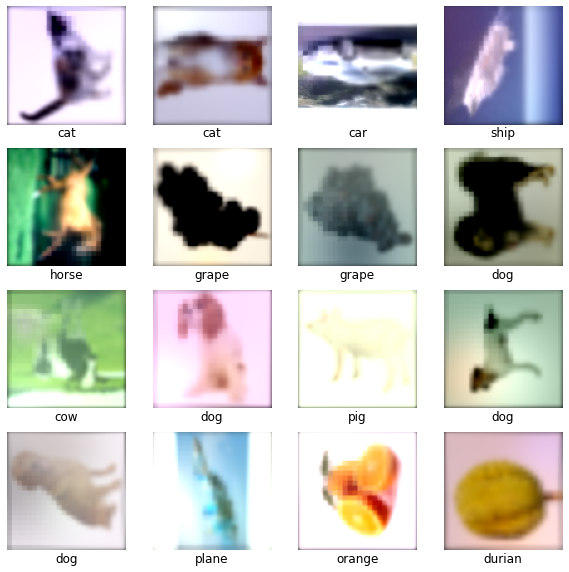

In [5]:
plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
    for i in range(16):
        ax = plt.subplot(4, 4, i + 1)
        plt.imshow(images[i] / 255)
        plt.title(class_names[labels[i]], y=-0.15)
        plt.axis("off")

In [6]:
export_path = f"D:/SmartCar/TFLite_Smartcar/saved_models/{int(time.time())}"
print(export_path)

model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=export_path,
    save_best_only=True,
    monitor="val_loss",
    mode='min',
)

historyViewer = HistoryViewer()

D:/SmartCar/TFLite_Smartcar/saved_models/1658421344


In [7]:
base_model, model = get_EfficientNetV2B1(IMG_SIZE, num_classes, trainable=False)
model.summary()

Model: "efficientnetv2-b1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input (InputLayer)          [(None, 96, 96, 3)]       0         
                                                                 
 efficientnetv2-b1 (Function  (None, 3, 3, 1280)       6931124   
 al)                                                             
                                                                 
 avg_pool (GlobalAveragePool  (None, 1280)             0         
 ing2D)                                                          
                                                                 
 top_dropout (Dropout)       (None, 1280)              0         
                                                                 
 dense (Dense)               (None, 15)                19215     
                                                                 
Total params: 6,950,339
Trainable params: 19,215


Epoch 1/25
1110/1110 [==============================] - 102s 83ms/step - loss: 1.6327 - accuracy: 0.5132 - val_loss: 1.0682 - val_accuracy: 0.6872
Epoch 2/25
1110/1110 [==============================] - 114s 102ms/step - loss: 1.0185 - accuracy: 0.6837 - val_loss: 0.8495 - val_accuracy: 0.7349
Epoch 3/25
1110/1110 [==============================] - 143s 129ms/step - loss: 0.8698 - accuracy: 0.7185 - val_loss: 0.7634 - val_accuracy: 0.7546
Epoch 4/25
1110/1110 [==============================] - 160s 143ms/step - loss: 0.8016 - accuracy: 0.7344 - val_loss: 0.6914 - val_accuracy: 0.7783
Epoch 5/25
1110/1110 [==============================] - 167s 150ms/step - loss: 0.7573 - accuracy: 0.7466 - val_loss: 0.6584 - val_accuracy: 0.7832
Epoch 6/25
1110/1110 [==============================] - 175s 157ms/step - loss: 0.7262 - accuracy: 0.7553 - val_loss: 0.6326 - val_accuracy: 0.7934
Epoch 7/25
1110/1110 [==============================] - 188s 169ms/step - loss: 0.7058 - accuracy: 0.7623 - val_l

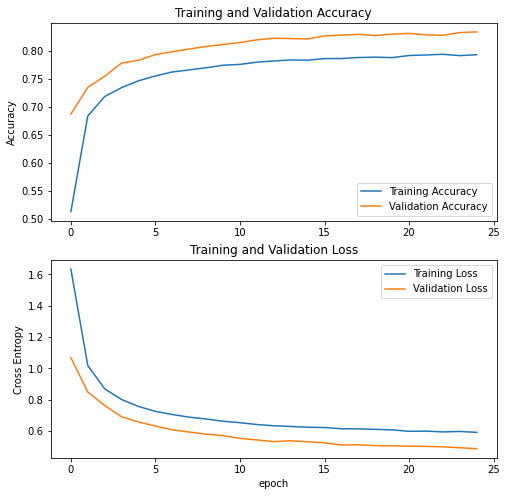

In [8]:
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=FREEZE_LR),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(),
    metrics=['accuracy']
)

history = model.fit(
    train_ds,
    initial_epoch=0,
    epochs=FREEZE_EPOCHS,
    validation_data=val_ds,
    # callbacks=[model_checkpoint_callback],
)
historyViewer.update(history)
historyViewer.show()

In [9]:
base_model.trainable = True
model.summary()

Model: "efficientnetv2-b1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input (InputLayer)          [(None, 96, 96, 3)]       0         
                                                                 
 efficientnetv2-b1 (Function  (None, 3, 3, 1280)       6931124   
 al)                                                             
                                                                 
 avg_pool (GlobalAveragePool  (None, 1280)             0         
 ing2D)                                                          
                                                                 
 top_dropout (Dropout)       (None, 1280)              0         
                                                                 
 dense (Dense)               (None, 15)                19215     
                                                                 
Total params: 6,950,339
Trainable params: 6,879,2

Epoch 26/50
1110/1110 [==============================] - 282s 239ms/step - loss: 1.1856 - accuracy: 0.6195 - val_loss: 0.6674 - val_accuracy: 0.7686
Epoch 27/50
1110/1110 [==============================] - 281s 253ms/step - loss: 0.7118 - accuracy: 0.7559 - val_loss: 0.4716 - val_accuracy: 0.8334
Epoch 28/50
1110/1110 [==============================] - 291s 261ms/step - loss: 0.5450 - accuracy: 0.8101 - val_loss: 0.3571 - val_accuracy: 0.8736
Epoch 29/50
1110/1110 [==============================] - 302s 271ms/step - loss: 0.4420 - accuracy: 0.8460 - val_loss: 0.2768 - val_accuracy: 0.9048
Epoch 30/50
1110/1110 [==============================] - 303s 272ms/step - loss: 0.3678 - accuracy: 0.8712 - val_loss: 0.2240 - val_accuracy: 0.9218
Epoch 31/50
1110/1110 [==============================] - 314s 282ms/step - loss: 0.3051 - accuracy: 0.8932 - val_loss: 0.1811 - val_accuracy: 0.9388
Epoch 32/50
1110/1110 [==============================] - 323s 291ms/step - loss: 0.2600 - accuracy: 0.9091

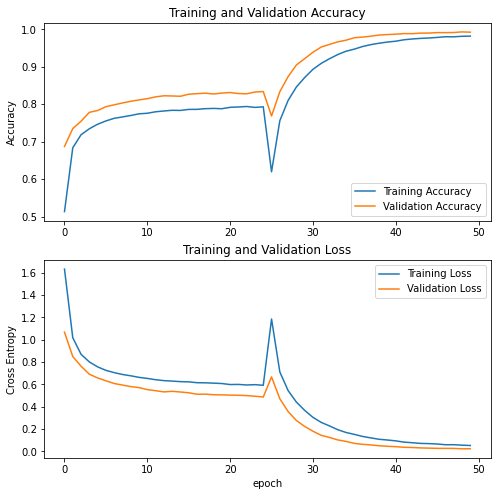

In [10]:
model.compile(
    optimizer=tf.keras.optimizers.RMSprop(learning_rate=UNFREEZE_LR),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(),
    metrics=['accuracy']
)

history = model.fit(
    train_ds,
    initial_epoch=FREEZE_EPOCHS,
    epochs=FREEZE_EPOCHS+UNFREEZE_EPOCHS,
    validation_data=val_ds,
    # callbacks=[model_checkpoint_callback],
)
historyViewer.update(history)
historyViewer.show()

In [11]:
model.save(export_path)

INFO:tensorflow:Assets written to: D:/SmartCar/TFLite_Smartcar/saved_models/1658421344\assets


INFO:tensorflow:Assets written to: D:/SmartCar/TFLite_Smartcar/saved_models/1658421344\assets
